# SUPERVISED MLP ON TCGA-BRCA 
Goal: train a simple MLP on the latent representations AE already implemented
-   Train/Test split already fixed from QC (patient-wise).
-	We split train → (train/val) only for model selection/early stopping.
-	Any encoder for labels is fit on train only.
-> Picking a target column from metadata is needed (check meta_train_postQC.csv)

In [133]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow import keras
from keras import layers

RANDOM_STATE = 42
tf.keras.utils.set_random_seed(RANDOM_STATE)

# Charger X fait suite au QC

In [134]:
X_train = np.load("./tcga_brca_qc_report/X_train_z.npy")
X_test  = np.load("./tcga_brca_qc_report/X_test_z.npy")

# tf/keras: float32 recommandé
X_train = np.asarray(X_train, dtype=np.float32)
X_test  = np.asarray(X_test, dtype=np.float32)

print("X_train:", X_train.shape, X_train.dtype)
print("X_test :", X_test.shape,  X_test.dtype)

X_train: (814, 10000) float32
X_test : (208, 10000) float32


But
-	Charger les features (probablement gènes) déjà pré-traitées.
-	Convertir en float32 (recommandé pour TF/Keras).

Entrées / Sorties
-	Entrées : fichiers .npy
-	Sorties : X_train, X_test prêts pour le modèle.

Les X sont déjà standardisé !

# Charger les méta et définir les colonnes de survies

In [135]:
""" temps: days_to_last follow_up or days_to_death
event: vital_status (dead or alive)
"""

meta_tr = pd.read_csv("./tcga_brca_qc_report/meta_train_postQC.csv")
meta_te = pd.read_csv("./tcga_brca_qc_report/meta_test_postQC.csv")


# temps (en jours) et event (dead or alive)
TIME_COL = "days_to_last_follow_up"    # car days_to_death a bcp trop de NaN
EVENT_COL = "vital_status"  

if TIME_COL not in meta_tr.columns or EVENT_COL not in meta_tr.columns:
    raise ValueError(
        f"TIME_COL/EVENT_COL non trouvées dans meta.\n"
        f"Colonnes meta_tr (extrait): {meta_tr.columns.tolist()[:40]}"
    )

t_train = pd.to_numeric(meta_tr[TIME_COL], errors="coerce").values
e_train = pd.to_numeric(meta_tr[EVENT_COL], errors="coerce").values

t_test  = pd.to_numeric(meta_te[TIME_COL], errors="coerce").values
e_test  = pd.to_numeric(meta_te[EVENT_COL], errors="coerce").values

print("Survival train:", np.nanmin(t_train), np.nanmax(t_train), "events:", np.nansum(e_train))
print("Survival test :", np.nanmin(t_test),  np.nanmax(t_test),  "events:", np.nansum(e_test))

Survival train: -7.0 8605.0 events: 0.0
Survival test : 0.0 5156.0 events: 0.0


But
-	Charger meta_tr/meta_te.
-	Fixer :
-	TIME_COL = days_to_last_follow_up (choisi car days_to_death a trop de NaN, d’après ton commentaire).
-	EVENT_COL = vital_status (encore au format texte à ce stade).
-	Vérifier l’existence des colonnes.
-	Convertir TIME_COL et EVENT_COL en numérique pour un check rapide.

Entrée : CSV meta post-QC

Sorties : meta_tr, meta_te et des vecteurs t_train, e_train, etc. (mais e_train ici n’est pas encore correctement défini si vital_status est du texte).

# Standardiser vital_status et création de event (Cox)

In [136]:
def standardize_vital_status(series):
    s = series.copy()

    # Cas numérique (0/1)
    s_num = pd.to_numeric(s, errors="coerce")
    vals = set(s_num.dropna().unique().tolist())
    if len(vals) > 0 and vals.issubset({0.0, 1.0}):
        return s_num

    # Cas texte ("Alive"/"Dead")
    s_txt = s.astype(str).str.strip().str.lower()
    return s_txt.map({"alive": 1, "dead": 0})


meta_tr["vital_status"] = standardize_vital_status(meta_tr["vital_status"])
meta_te["vital_status"] = standardize_vital_status(meta_te["vital_status"])

# Convention Cox : event = 1 si décès
meta_tr["event"] = 1 - meta_tr["vital_status"]
meta_te["event"] = 1 - meta_te["vital_status"]

print("vital_status train:")
print(meta_tr["vital_status"].value_counts(dropna=False))
print("vital_status test:")
print(meta_te["vital_status"].value_counts(dropna=False))

vital_status train:
vital_status
1.0    694
0.0    119
NaN      1
Name: count, dtype: int64
vital_status test:
vital_status
1    186
0     22
Name: count, dtype: int64


## Refaire l'alignement 
Certains NaN on pu se glisser, ou on peut avoir pris le mauvais fichier
Cellule de checking, on supprime les NaN

In [137]:
TIME_COL = "days_to_last_follow_up"
EVENT_COL = "event"

time_tr  = pd.to_numeric(meta_tr[TIME_COL], errors="coerce")
event_tr = pd.to_numeric(meta_tr[EVENT_COL], errors="coerce")

mask_tr = time_tr.notna() & (time_tr > 0) & event_tr.notna() & event_tr.isin([0, 1])

X_train = X_train[mask_tr.values]
meta_tr = meta_tr.loc[mask_tr].reset_index(drop=True)

time_te  = pd.to_numeric(meta_te[TIME_COL], errors="coerce")
event_te = pd.to_numeric(meta_te[EVENT_COL], errors="coerce")

mask_te = time_te.notna() & (time_te > 0) & event_te.notna() & event_te.isin([0, 1])

X_test = X_test[mask_te.values]
meta_te = meta_te.loc[mask_te].reset_index(drop=True)

print("Aligned train:", X_train.shape, meta_tr.shape)
print("Aligned test :", X_test.shape, meta_te.shape)

Aligned train: (795, 10000) (795, 91)
Aligned test : (206, 10000) (206, 91)


In [138]:
# verifie le nombre de alive et dead après le mapping
print(meta_tr["vital_status"].value_counts(dropna=False))
print(meta_te["vital_status"].value_counts(dropna=False))

vital_status
1.0    678
0.0    117
Name: count, dtype: int64
vital_status
1    184
0     22
Name: count, dtype: int64


# Checker les NaN
Si malgré le re-alignement on a des NaN, checker pour les supprimer

In [139]:
# Check combien de NaN dans event et time restent et si event est bien en binaire
print("NaN event train:", meta_tr["event"].isna().sum())
print("NaN event test :", meta_te["event"].isna().sum())

print("Unique event train:", meta_tr["event"].dropna().unique()[:10])
print("Unique event test :", meta_te["event"].dropna().unique()[:10])

print("NaN time train:", meta_tr["days_to_last_follow_up"].isna().sum())
print("NaN time test :", meta_te["days_to_last_follow_up"].isna().sum())

NaN event train: 0
NaN event test : 0
Unique event train: [0. 1.]
Unique event test : [0 1]
NaN time train: 0
NaN time test : 0


In [140]:
assert meta_tr["event"].isna().sum() == 0
assert meta_te["event"].isna().sum() == 0
assert (meta_tr["days_to_last_follow_up"] > 0).all()
assert (meta_te["days_to_last_follow_up"] > 0).all()

print("Survival data clean and aligned ✔")

Survival data clean and aligned ✔


# Split intern /validation 
À vérifier
-	Event rate ≠ 0
-	X_val.shape[0] ≈ 10–20 % du train

In [141]:
val_frac = 0.15

n = X_train.shape[0]
idx = np.arange(n)
np.random.default_rng(RANDOM_STATE).shuffle(idx)

n_val = int(val_frac * n)
val_idx = idx[:n_val]
tr_idx  = idx[n_val:]

X_tr  = X_train[tr_idx]
X_val = X_train[val_idx]

t_tr  = meta_tr.iloc[tr_idx]["days_to_last_follow_up"].astype(np.float32).values
t_val = meta_tr.iloc[val_idx]["days_to_last_follow_up"].astype(np.float32).values

e_tr  = meta_tr.iloc[tr_idx]["event"].astype(np.float32).values
e_val = meta_tr.iloc[val_idx]["event"].astype(np.float32).values

print("Train:", X_tr.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)
print("Event rate (train):", e_tr.mean())

Train: (676, 10000)
Val  : (119, 10000)
Test : (206, 10000)
Event rate (train): 0.147929


But
-	Split aléatoire de X_train en X_tr et X_val.
-	Récupérer les labels de survie alignés via meta_tr.iloc[...].

# Loss Cox partial likelihood

In [142]:
def cox_ph_loss(t, e, r, eps=1e-8):
    # shapes
    t = tf.reshape(tf.cast(t, tf.float32), [-1])
    e = tf.reshape(tf.cast(e, tf.float32), [-1])
    r = tf.reshape(tf.cast(r, tf.float32), [-1])

    # sort by descending time
    order = tf.argsort(t, direction="DESCENDING")
    e = tf.gather(e, order)
    r = tf.gather(r, order)

    # numeric stabilization: subtract max before exp, then add it back
    r_max = tf.reduce_max(r)
    r_stab = r - r_max

    # log(sum_{j in risk set} exp(r_j)) via log(cumsum(exp(.)))
    log_cum_sum_exp = tf.math.log(tf.cumsum(tf.exp(r_stab)) + eps) + r_max

    pll = tf.reduce_sum(e * (r - log_cum_sum_exp))
    n_events = tf.reduce_sum(e) + eps
    return -pll / n_events

But
-	Implémenter la negative partial log-likelihood de Cox :
-	On trie par temps décroissant pour construire les “risk sets”.
-	log_cum_sum_exp approxime log(Σ exp(r_j)) sur le risk set.
-	On somme seulement sur les individus avec e=1 (décès).
-	On normalise par le nombre d’événements.

Ici, r est la sortie du réseau (score). La Cox ne prédit pas directement un temps, mais un ordre relatif de risque.

# MLP survie (baseline)

In [143]:
n_features = X_tr.shape[1]

inputs = keras.Input(shape=(n_features,))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)

risk = layers.Dense(1, activation=None)(x)

mlp = keras.Model(inputs, risk, name="MLP_Cox")
mlp.summary()

Model: "MLP_Cox"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

But
-	Réseau fully-connected qui produit un score de risque scalaire.
-	Dropout pour régulariser.

Entrée : vecteur de features (n_features,)

Sortie : risk de forme (batch, 1)

# Stocker historique pendant training

In [144]:
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_cindex": [],
}

best_epoch = None

In [145]:
# C-index de Harrell
def harrell_c_index(t, e, risk):
    t = np.asarray(t).reshape(-1)
    e = np.asarray(e).reshape(-1)
    risk = np.asarray(risk).reshape(-1)

    concordant = 0.0
    permissible = 0.0
    ties = 0.0

    n = len(t)
    for i in range(n):
        if e[i] != 1:
            continue
        for j in range(n):
            if t[j] <= t[i]:
                continue
            permissible += 1
            if risk[i] > risk[j]:
                concordant += 1
            elif risk[i] == risk[j]:
                ties += 1

    if permissible == 0:
        return np.nan
    return (concordant + 0.5 * ties) / permissible

# Entrainement MLP

In [146]:
optimizer = keras.optimizers.Adam(1e-3)

@tf.function
def train_step(x, t, e):
    with tf.GradientTape() as tape:
        r = mlp(x, training=True)
        loss = cox_ph_loss(t, e, r)
    grads = tape.gradient(loss, mlp.trainable_weights)
    optimizer.apply_gradients(zip(grads, mlp.trainable_weights))
    return loss

@tf.function
def val_step(x, t, e):
    r = mlp(x, training=False)
    return cox_ph_loss(t, e, r)

BATCH = 64
EPOCHS = 200
PATIENCE = 15

best_val = np.inf
pat = 0

for epoch in range(1, EPOCHS + 1):

    # ---- TRAIN ----
    idx = np.arange(X_tr.shape[0])
    np.random.default_rng(SEED).shuffle(idx)

    tr_losses = []
    for i in range(0, len(idx), BATCH):
        j = idx[i:i+BATCH]
        tr_losses.append(
            float(train_step(X_tr[j], t_tr[j], e_tr[j]).numpy())
        )
    tr_loss = np.mean(tr_losses)

    # ---- VALIDATION ----
    val_losses = []
    for i in range(0, X_val.shape[0], BATCH):
        val_losses.append(
            float(val_step(
                X_val[i:i+BATCH],
                t_val[i:i+BATCH],
                e_val[i:i+BATCH]
            ).numpy())
        )
    va_loss = np.mean(val_losses)
    
    # C-index sur validation (plus grand = mieux)
    risk_val = mlp(X_val, training=False).numpy().reshape(-1)
    cidx_val = harrell_c_index(t_val, e_val, risk_val)

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_cindex"].append(cidx_val)

    print(f"Epoch {epoch:03d} | train={tr_loss:.4f} | val={va_loss:.4f} | val_cindex={cidx_val:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_epoch = epoch
        pat = 0
        mlp.save("best_mlp_cox.keras")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping")
            break

Epoch 001 | train=21.2738 | val=18.7762 | val_cindex=0.5216
Epoch 002 | train=25.6660 | val=14.0430 | val_cindex=0.3377
Epoch 003 | train=31.9764 | val=21.3794 | val_cindex=0.3879
Epoch 004 | train=53.0641 | val=34.4448 | val_cindex=0.3930
Epoch 005 | train=69.0371 | val=22.6782 | val_cindex=0.4362
Epoch 006 | train=84.6185 | val=56.9684 | val_cindex=0.4322
Epoch 007 | train=131.8715 | val=27.1220 | val_cindex=0.4271
Epoch 008 | train=136.7046 | val=21.6418 | val_cindex=0.4472
Epoch 009 | train=197.3870 | val=53.3375 | val_cindex=0.4332
Epoch 010 | train=224.1023 | val=25.4570 | val_cindex=0.4221
Epoch 011 | train=262.2950 | val=90.3453 | val_cindex=0.4141
Epoch 012 | train=388.9266 | val=68.1100 | val_cindex=0.4060
Epoch 013 | train=353.4766 | val=101.3780 | val_cindex=0.3950
Epoch 014 | train=432.8963 | val=77.8106 | val_cindex=0.4020
Epoch 015 | train=467.8846 | val=156.9122 | val_cindex=0.4171
Epoch 016 | train=534.4465 | val=282.7596 | val_cindex=0.4080
Epoch 017 | train=522.1996 

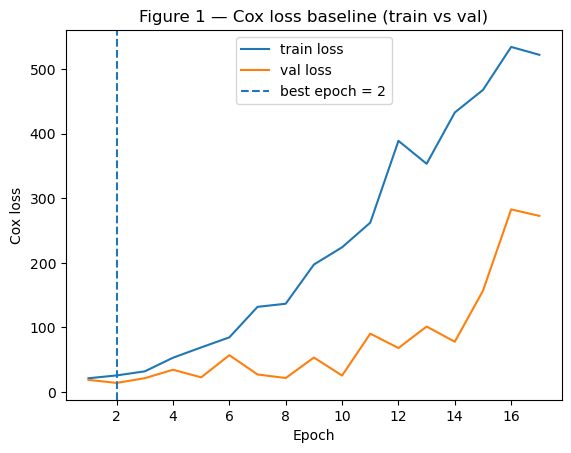

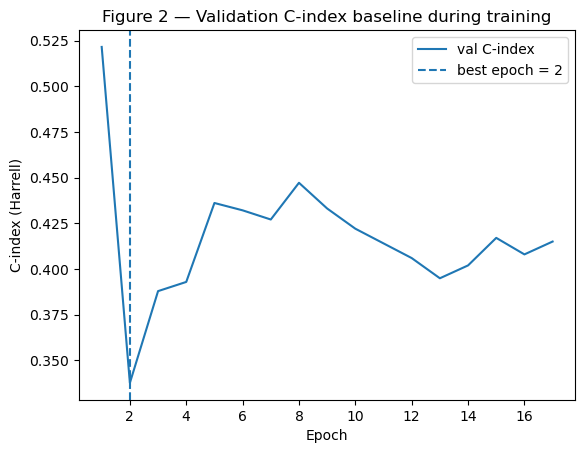

In [147]:
# ---- Figure 1: Cox loss curves ----
plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="train loss")
plt.plot(history["epoch"], history["val_loss"], label="val loss")
if best_epoch is not None:
    plt.axvline(best_epoch, linestyle="--", label=f"best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Cox loss")
plt.title("Figure 1 — Cox loss baseline (train vs val)")
plt.legend()
plt.show()

# ---- Figure 2: Validation C-index over epochs ----
plt.figure()
plt.plot(history["epoch"], history["val_cindex"], label="val C-index")
if best_epoch is not None:
    plt.axvline(best_epoch, linestyle="--", label=f"best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("C-index (Harrell)")
plt.title("Figure 2 — Validation C-index baseline during training")
plt.legend()
plt.show()

# Evaluation sur le C-index

In [148]:
best = keras.models.load_model("best_mlp_cox.keras", compile=False)

risk_test = best.predict(X_test, batch_size=256).reshape(-1)

t_test = meta_te["days_to_last_follow_up"].astype(np.float32).values
e_test = meta_te["event"].astype(np.float32).values

def harrell_c_index(t, e, risk):
    n = len(t)
    num = 0.0
    den = 0.0
    for i in range(n):
        if e[i] != 1:
            continue
        for j in range(n):
            if t[j] > t[i]:
                den += 1
                if risk[i] > risk[j]:
                    num += 1
                elif risk[i] == risk[j]:
                    num += 0.5
    return num / den if den > 0 else np.nan

cidx = harrell_c_index(t_test, e_test, risk_test)
print("Test C-index:", cidx)
print ("best epoch:", best_epoch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Test C-index: 0.4595680562531391
best epoch: 2


But
-	Charger le meilleur modèle sauvegardé.
-	Prédire un score de risque sur le test.
-	Calculer le C-index :
	-	On ne compare que des paires “comparables” où l’un a eu l’événement (e[i]==1) et où l’autre a un temps plus long (t[j] > t[i]).
	-	Concordant si risk[i] > risk[j] (celui qui meurt plus tôt a un risque plus élevé).
	-	Gestion des égalités à 0.5.

# Export des données pour analyse biologique

In [149]:
# ============================================================
# Export des risk scores — MLP BASELINE (TEST uniquement)
# ============================================================

import os
import numpy as np
import pandas as pd

EXPORT_DIR = "./results_risk"
os.makedirs(EXPORT_DIR, exist_ok=True)

RUN_NAME = "MLP_BASELINE"
ID_COL = "submitter_id"
TIME_COL = "days_to_last_follow_up"
EVENT_COL = "event"

df_test = pd.DataFrame({
    ID_COL: meta_te[ID_COL].astype(str).values,
    "split": "test",
    "risk_score": np.asarray(risk_test).reshape(-1),
    "time": meta_te[TIME_COL].astype(float).values,
    "event": meta_te[EVENT_COL].astype(int).values
})

out_path = os.path.join(EXPORT_DIR, f"{RUN_NAME}_risk_test.csv")
df_test.to_csv(out_path, index=False)

# optionnel : risk_all = risk_test (cohérence avec les autres runs)
df_test.to_csv(os.path.join(EXPORT_DIR, f"{RUN_NAME}_risk_all.csv"), index=False)

print("Saved:", out_path)

Saved: ./results_risk/MLP_BASELINE_risk_test.csv


# GO enrichment

In [151]:
# GO ENRICHMENT
# Ce code utilise directement les variables déjà présentes dans le notebook

import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# ------------------------------------------------------------
# Configuration

RUN_NAME = "MLP_BASELINE"  #a changer selon notebook

OUTDIR = f"./interpretation_{RUN_NAME}"
os.makedirs(OUTDIR, exist_ok=True)

TOP_N = 300  # Nombre de top gènes
DO_GO = True  

# ------------------------------------------------------------
# 1. Charger les gene names (depuis ton QC)
#

gene_names_path = "./tcga_brca_qc_report/gene_names.npy"

if not os.path.exists(gene_names_path):
    print(f"  Gene names file not found: {gene_names_path}")
    print("Creating gene_names from column names...")
    # Si le fichier n'existe pas, tu peux le créer une fois à partir d'un CSV
    # ou utiliser un placeholder
    gene_names = [f"GENE_{i}" for i in range(X_test.shape[1])]
else:
    gene_names = np.load(gene_names_path, allow_pickle=True).astype(str)

print(f"✓ Loaded {len(gene_names)} gene names")

# ------------------------------------------------------------
# 2. Variables déjà présentes dans le notebook
#
# X_test : déjà chargé (shape: n_samples × n_genes)
# risk_test : déjà calculé par le MLP (shape: n_samples,)
# meta_te : déjà chargé (contient submitter_id)

print(f"✓ X_test shape: {X_test.shape}")
print(f"✓ Risk scores: {len(risk_test)}")
print(f"✓ Meta test: {len(meta_te)}")

# Récupérer les sample IDs
sample_ids = meta_te["submitter_id"].astype(str).values

# -----------------------------------------------------------
# 3. Créer le DataFrame d'expression
#
expr_df = pd.DataFrame(
    X_test,
    index=sample_ids,
    columns=gene_names
)

# --------------------------------------------------------------
# 4. Calculer corrélation Spearman : expression envrion égalle au risk_score
#
print("\n" + "="*60)
print("Calculating gene-risk correlations...")
print("="*60)

rows = []
for i, gene in enumerate(gene_names):
    if i % 1000 == 0:
        print(f"  Progress: {i}/{len(gene_names)} genes...")
    
    gene_expr = expr_df[gene].values
    r, pval = spearmanr(gene_expr, risk_test)
    rows.append((gene, r, pval))

rank_df = pd.DataFrame(rows, columns=["gene", "spearman_r", "pvalue"])
rank_df["abs_r"] = rank_df["spearman_r"].abs()
rank_df["qvalue"] = multipletests(rank_df["pvalue"].values, method="fdr_bh")[1]
rank_df = rank_df.sort_values("abs_r", ascending=False).reset_index(drop=True)

# Sauvegarder le ranking complet
out_rank = os.path.join(OUTDIR, "gene_risk_correlation.csv")
rank_df.to_csv(out_rank, index=False)
print(f"\n✓ Saved full gene ranking: {out_rank}")

# ------------------------------------------------------------
# 5. Top gènes
#
top_genes = rank_df["gene"].head(TOP_N).tolist()
out_top = os.path.join(OUTDIR, f"top_{TOP_N}_genes.txt")
with open(out_top, "w") as f:
    f.write("\n".join(top_genes))

print(f"✓ Saved top {TOP_N} genes: {out_top}")

# Afficher top 10
print(f"\nTop 10 genes correlated with {RUN_NAME} risk score:")
print(f"{'Rank':<6} {'Gene':<15} {'Spearman r':<12} {'P-value':<12} {'Q-value':<12}")
print("-" * 60)
for i, gene in enumerate(top_genes[:10], 1):
    row = rank_df[rank_df["gene"] == gene].iloc[0]
    print(f"{i:<6} {gene:<15} {row['spearman_r']:>+10.4f}  {row['pvalue']:>10.2e}  {row['qvalue']:>10.2e}")

# Statistiques
sig_genes = rank_df[rank_df["qvalue"] < 0.05]
pos_corr = sig_genes[sig_genes["spearman_r"] > 0]
neg_corr = sig_genes[sig_genes["spearman_r"] < 0]

print(f"\nStatistics:")
print(f"  Total genes analyzed: {len(rank_df)}")
print(f"  Significant genes (FDR < 0.05): {len(sig_genes)}")
print(f"    - Positively correlated (high expr → high risk): {len(pos_corr)}")
print(f"    - Negatively correlated (high expr → low risk): {len(neg_corr)}")

# -----------------------------------------------------------
# 6. GO Enrichment
#
if DO_GO:
    try:
        import gseapy as gp
        
        print("\n" + "="*60)
        print("Running GO enrichment...")
        print("="*60)
        
        GO_LIBRARY = "GO_Biological_Process_2021"
        go_outdir = os.path.join(OUTDIR, "go_enrichr")
        os.makedirs(go_outdir, exist_ok=True)
        
        enr = gp.enrichr(
            gene_list=top_genes,  # Les gènes les plus corrélés au risk du MLP
            gene_sets=[GO_LIBRARY],
            organism="Human",
            outdir=go_outdir,
            cutoff=0.05
        )
        
        if hasattr(enr, "results") and enr.results is not None and len(enr.results) > 0:
            out_go = os.path.join(OUTDIR, "go_enrichment.csv")
            enr.results.to_csv(out_go, index=False)
            print(f"\n✓ Saved GO enrichment results: {out_go}")
            print(f"  Found {len(enr.results)} significant GO terms (FDR < 0.05)")
            
            # Top 5 termes
            print("\nTop 5 enriched biological processes:")
            print(f"{'Rank':<6} {'Term':<50} {'P-value':<12} {'Genes'}")
            print("-" * 100)
            for i, row in enr.results.head(5).iterrows():
                term = row['Term'][:47] + "..." if len(row['Term']) > 50 else row['Term']
                genes = row['Genes'][:30] + "..." if len(row['Genes']) > 30 else row['Genes']
                print(f"{i+1:<6} {term:<50} {row['P-value']:>10.2e}  {genes}")
        else:
            print("\n  No significant GO terms found (FDR < 0.05)")
            print("   This might indicate:")
            print("   - Top genes are not part of known pathways")
            print("   - Need to increase TOP_N parameter")
            print("   - Gene names format issue")
            
    except ImportError:
        print("\n  gseapy not installed. Skipping GO enrichment.")
        print("   Install with: pip install gseapy")
    except Exception as e:
        print(f"\n  GO enrichment failed: {e}")
        print("   (Normal if no internet connection)")

# ------------------------------------------------------------
# Summary
#
print("\n" + "="*60)
print(f"✓ Biological interpretation completed for {RUN_NAME}")
print(f"  Results directory: {OUTDIR}")
print(f"  - Gene ranking: gene_risk_correlation.csv")
print(f"  - Top genes: top_{TOP_N}_genes.txt")
if DO_GO:
    print(f"  - GO enrichment: go_enrichment.csv")
print("="*60 + "\n")


✓ Loaded 10000 gene names
✓ X_test shape: (206, 10000)
✓ Risk scores: 206
✓ Meta test: 206

Calculating gene-risk correlations...
  Progress: 0/10000 genes...
  Progress: 1000/10000 genes...
  Progress: 2000/10000 genes...
  Progress: 3000/10000 genes...
  Progress: 4000/10000 genes...
  Progress: 5000/10000 genes...
  Progress: 6000/10000 genes...
  Progress: 7000/10000 genes...
  Progress: 8000/10000 genes...
  Progress: 9000/10000 genes...

✓ Saved full gene ranking: ./interpretation_MLP_BASELINE/gene_risk_correlation.csv
✓ Saved top 300 genes: ./interpretation_MLP_BASELINE/top_300_genes.txt

Top 10 genes correlated with MLP_BASELINE risk score:
Rank   Gene            Spearman r   P-value      Q-value     
------------------------------------------------------------
1      SRSF2              -0.6825    1.36e-29    1.36e-25
2      SNRPA              -0.6658    9.53e-28    4.77e-24
3      PSMA5              -0.6492    4.93e-26    1.64e-22
4      TARDBP             -0.6460    1.02e-25 